In [90]:
import glob
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
from sklearn import feature_extraction as fe
from nltk.stem.snowball import SnowballStemmer


## Exercise 1a)

First, we import the texts and source site from the files:

In [36]:
dir_path = "../data/pan"
txt_files = glob.glob("problem-*.txt", root_dir = dir_path)
json_files = glob.glob("truth-problem-*.json", root_dir=dir_path)

buffer_dict = []
for (txt_path, json_path) in zip(txt_files,json_files): # read all files and concatenate the relevant content into a dictionary
    txt_path = dir_path + "/" + txt_path
    json_path = dir_path + "/" + json_path
    with open(json_path) as json_f:
        json_dict = json.load(json_f)
        with open(txt_path) as txt_f:
            txt_content = txt_f.read()
            d= {
                "problem_txt": txt_content,
                "problem_site": json_dict["site"]
            }
            buffer_dict.append(d)



raw_df = pd.DataFrame(buffer_dict)
raw_df["problem_site"].unique()





array(['mathoverflow.net', 'philosophy', 'worldbuilding', 'history',
       'fitness', 'workplace', 'codereview', 'buddhism', 'bicycles',
       'serverfault.com', 'skeptics', 'dba', 'outdoors', 'astronomy',
       'economics', 'earthscience', 'literature', 'linguistics', 'sports'],
      dtype=object)

Next, we compute our ngrams with sklearn countVectorizer (ex 1b):

In [37]:
vect1 = fe.text.CountVectorizer(ngram_range=(1,1))
mat1 = vect1.fit_transform(raw_df["problem_txt"])

In [38]:
vect2 = fe.text.CountVectorizer(ngram_range=(2,2))
mat2 = vect2.fit_transform(raw_df["problem_txt"])

In [39]:
vect3 = fe.text.CountVectorizer(ngram_range=(3,3))
mat3 = vect3.fit_transform(raw_df["problem_txt"])

An n gram means that we pick out n words at a time for our bag of words model; *Bag of words* refers to a vector notation were we count the occurences for each  possible word (or gram) in our input text. Bag of words notation is very sparse, since most entries are 0 count entries.

Since we obtained the matrix, lets sum up the entries so we can see which ngrams are most common in our dataset:

In [50]:
def get_ngram_freq_ranking(mat,vec,ranking=25):
    summed_grams = mat.sum(axis=0)
    words_freq = [(word, summed_grams[0,i]) for word, i in vec.vocabulary_.items()] # get an indexed list where each ngram is key and count of that ngram is val
    words_freq = sorted(words_freq, key= lambda x: x[1], reverse=True)
    return dict(words_freq[:ranking])



Next, we need to plot the ranking for 1-grams, 2 grams and 3 grams over the whole dataset:

In [51]:
ranking1 = get_ngram_freq_ranking(mat1, vect1)
ranking2 = get_ngram_freq_ranking(mat2, vect2)
ranking3 = get_ngram_freq_ranking(mat3, vect3)
ranking1

{'the': 897318,
 'to': 489344,
 'of': 416040,
 'and': 352429,
 'is': 332516,
 'in': 278562,
 'you': 260670,
 'that': 259713,
 'it': 227093,
 'for': 159859,
 'be': 150638,
 'this': 141588,
 'are': 127193,
 'as': 124347,
 'not': 114423,
 'on': 114005,
 'with': 108662,
 'if': 108404,
 'have': 103015,
 'or': 99420,
 'can': 96762,
 'your': 94317,
 'but': 93846,
 'an': 71277,
 'there': 70919}

## 1b)


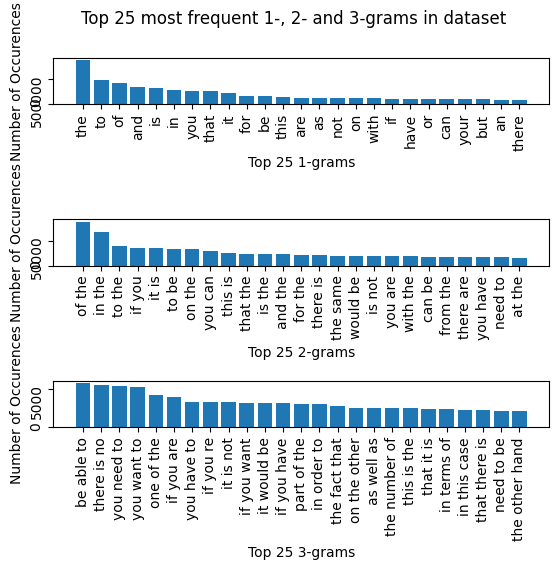

In [79]:
def show_1_2_3_gram_plots(ranking1,ranking2,ranking3, title = "Top 25 most frequent 1-, 2- and 3-grams in dataset"):
    fig, axs = plt.subplots(3)
    fig.suptitle(title)
    fig.subplots_adjust(hspace=2.5)

    axs[0].set_xlabel("Top 25 1-grams")
    axs[0].set_ylabel("Number of Occurences")
    axs[1].set_xlabel("Top 25 2-grams")
    axs[1].set_ylabel("Number of Occurences")
    axs[2].set_xlabel("Top 25 3-grams")
    axs[2].set_ylabel("Number of Occurences")


    axs[0].bar(x=range(len(ranking1)), height=list(ranking1.values()))
    axs[0].set_xticks(range(len(ranking1)), list(ranking1.keys()))
    axs[0].tick_params(labelrotation=90)

    axs[1].bar(x=range(len(ranking2)), height=list(ranking2.values()))
    axs[1].set_xticks(range(len(ranking2)), list(ranking2.keys()))
    axs[1].tick_params(labelrotation=90)

    axs[2].bar(x=range(len(ranking3)), height=list(ranking3.values()))
    axs[2].set_xticks(range(len(ranking3)), list(ranking3.keys()))
    axs[2].tick_params(labelrotation=90)

    plt.show()

show_1_2_3_gram_plots(ranking1,ranking2,ranking3)

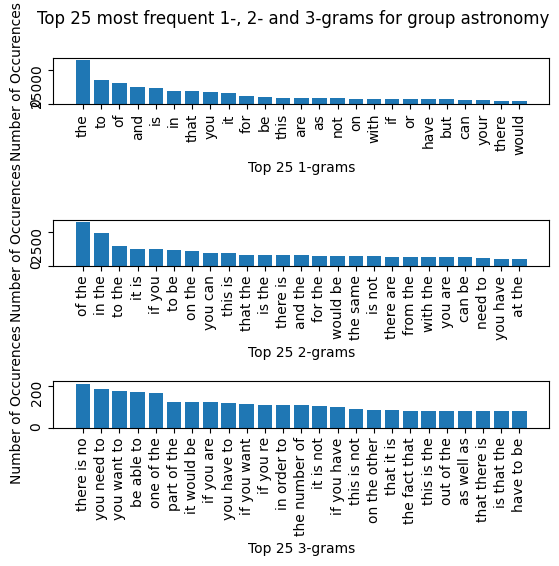

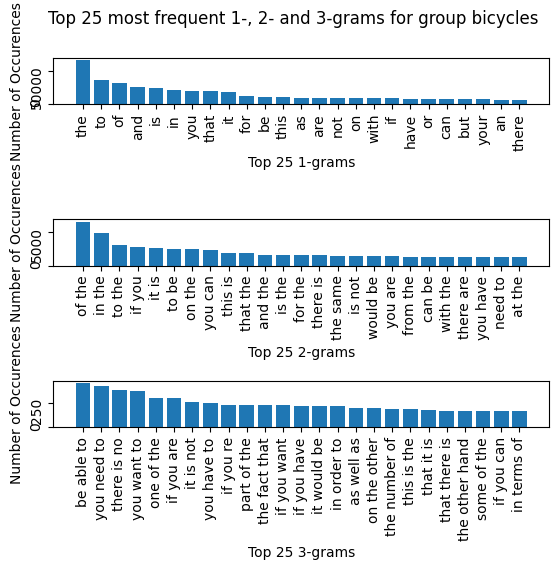

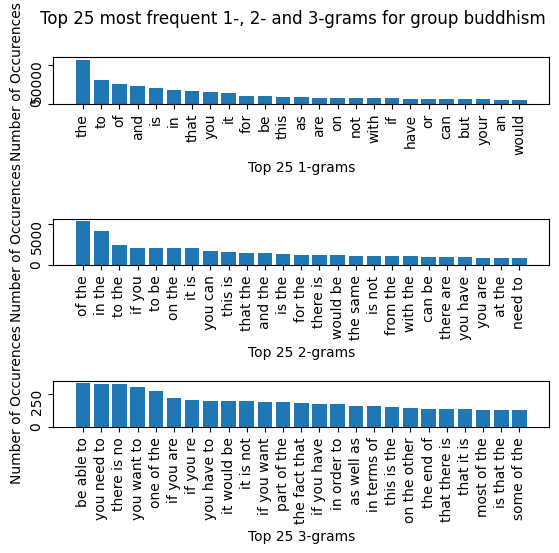

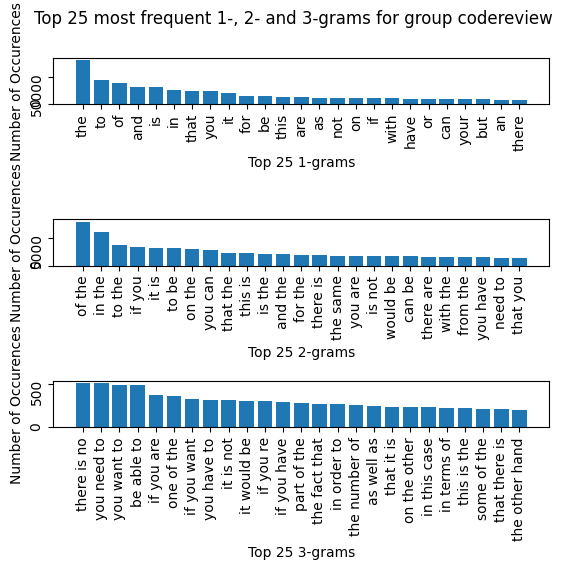

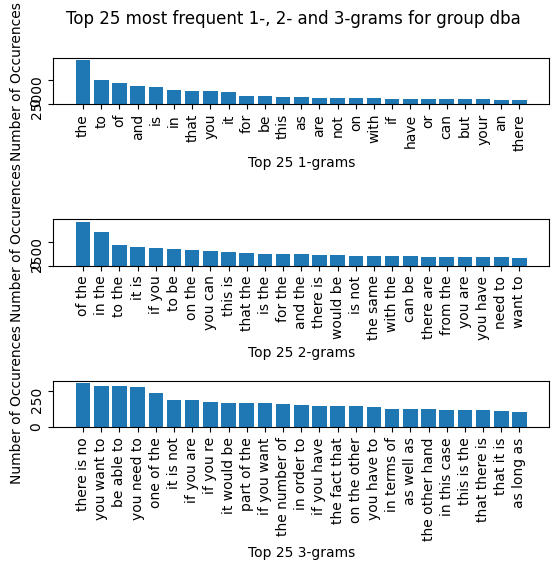

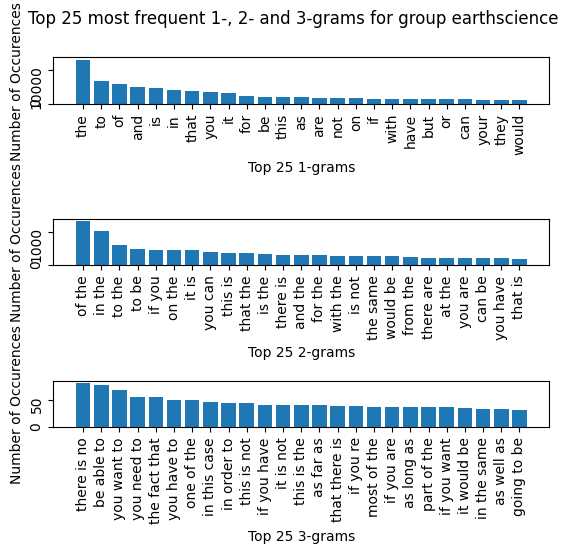

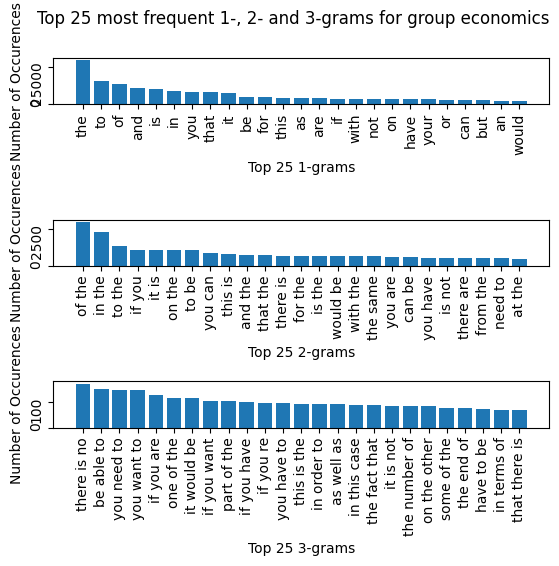

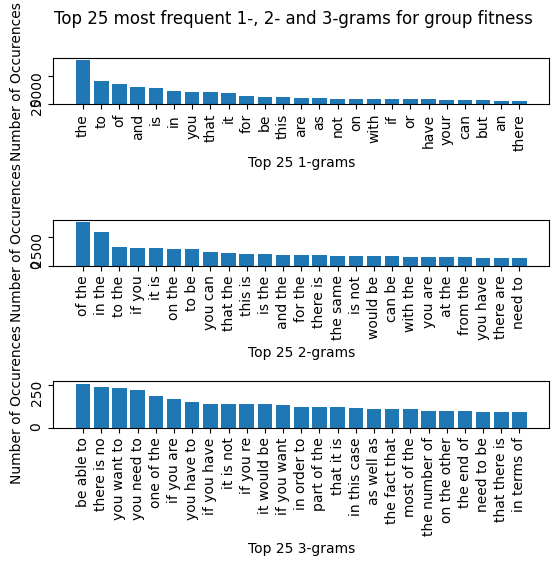

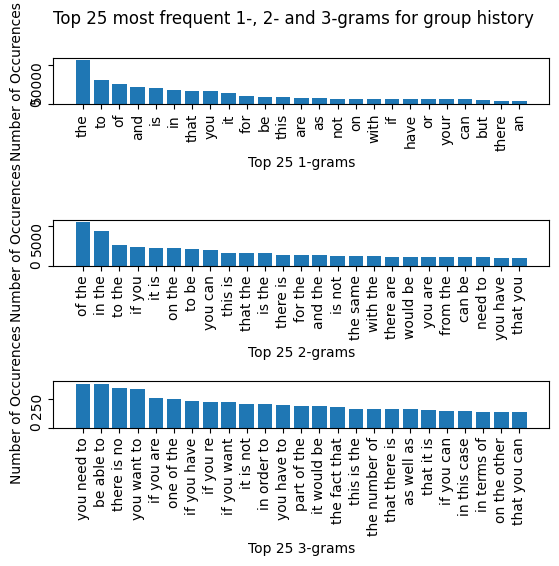

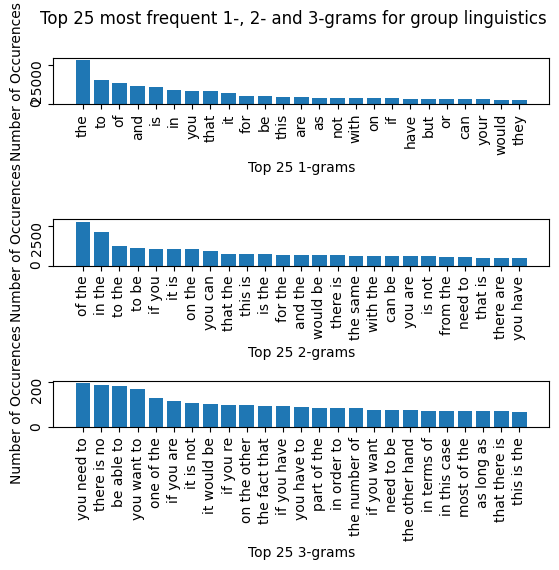

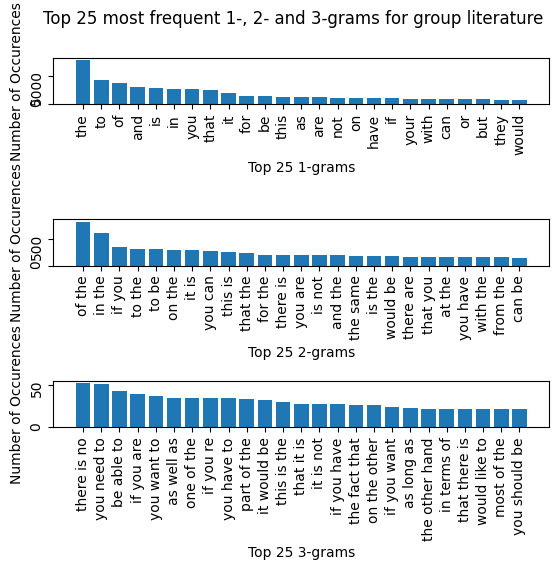

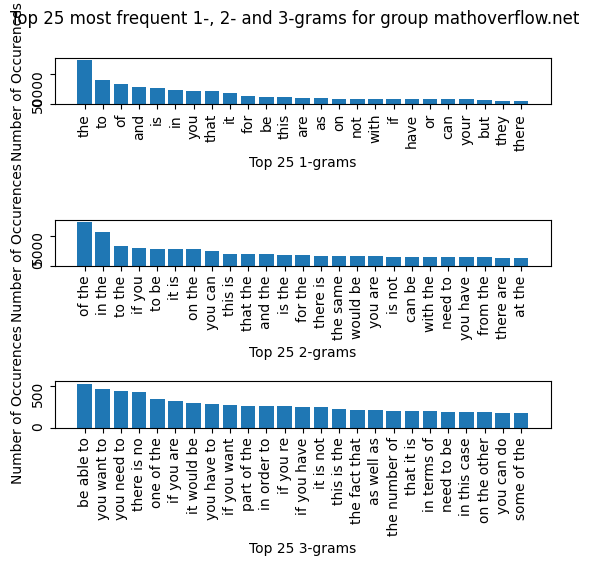

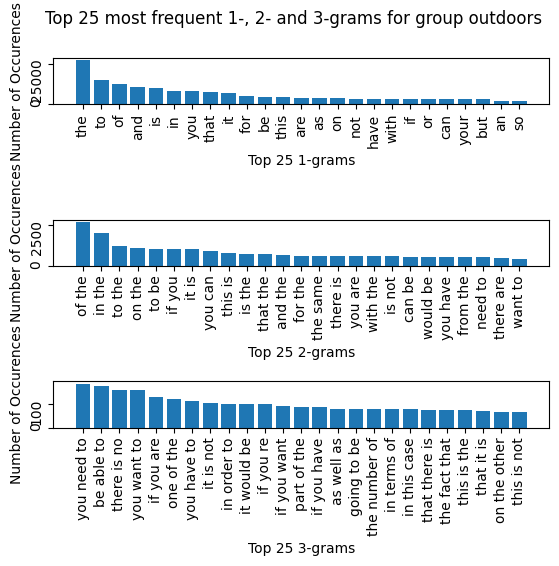

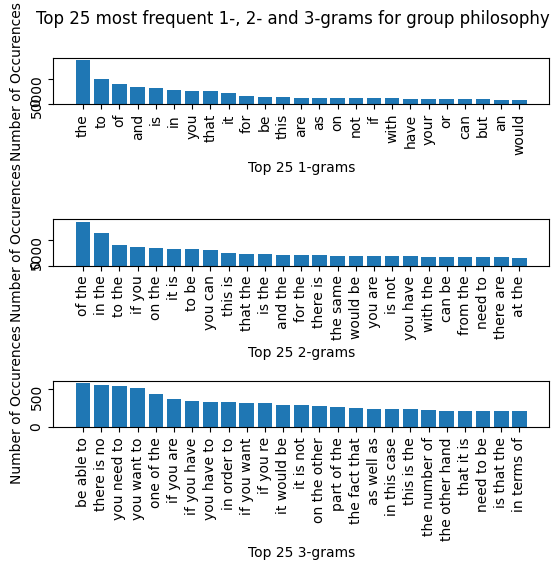

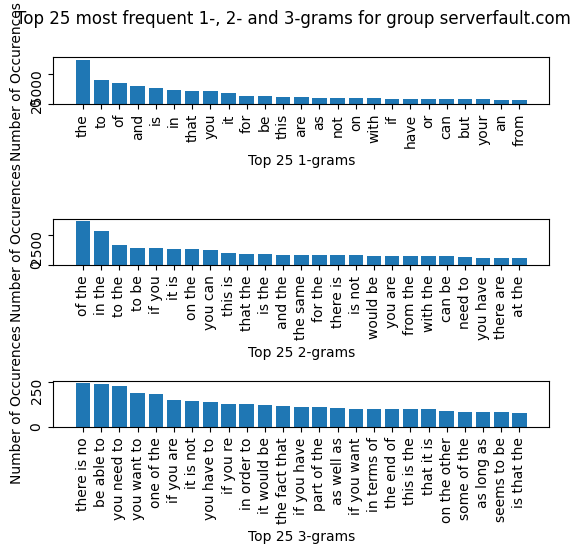

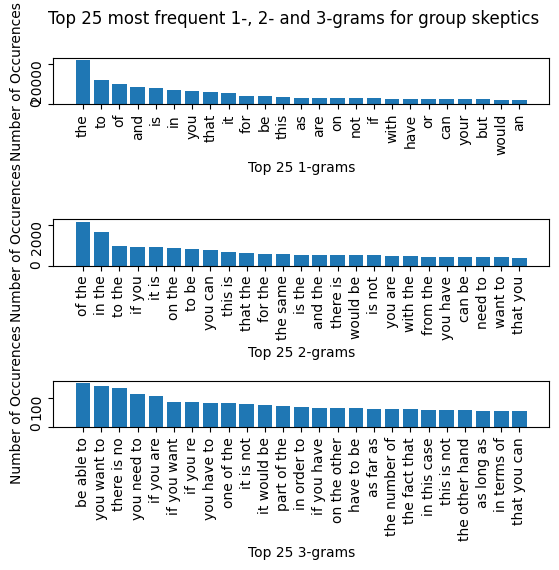

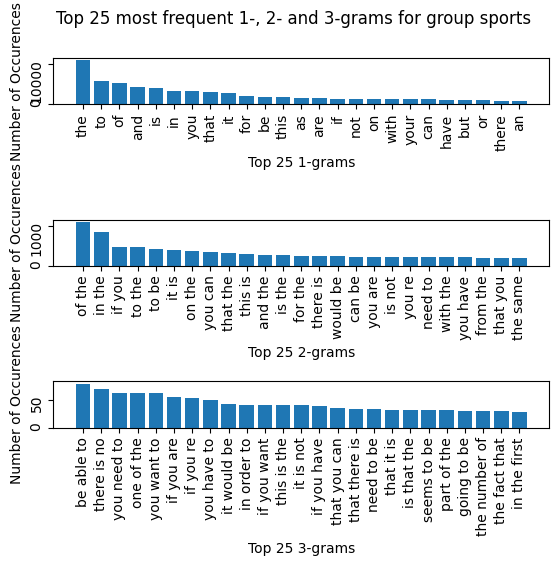

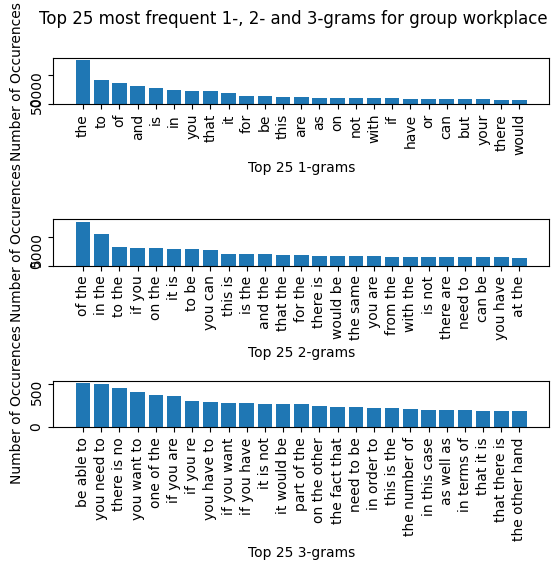

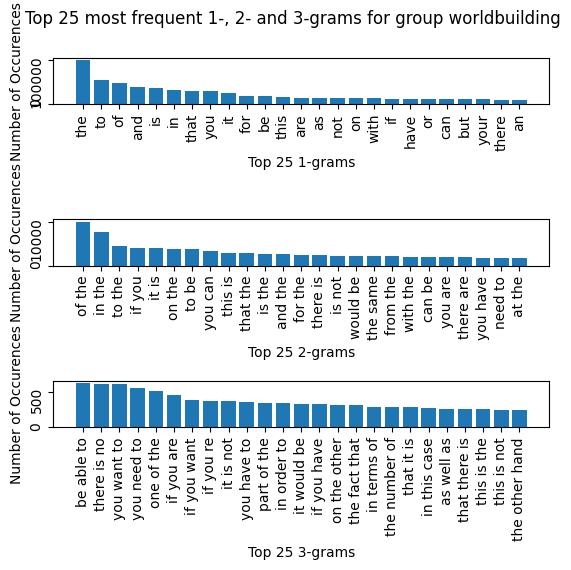

In [89]:
group_site= raw_df.groupby("problem_site")

for group in group_site.__iter__():
    vectg_1 = fe.text.CountVectorizer(ngram_range=(1,1))
    matg_1 = vectg_1.fit_transform(group[1]["problem_txt"])
    vectg_2 = fe.text.CountVectorizer(ngram_range=(2,2))
    matg_2 = vectg_2.fit_transform(group[1]["problem_txt"])
    vectg_3 = fe.text.CountVectorizer(ngram_range=(3,3))
    matg_3 = vectg_3.fit_transform(group[1]["problem_txt"])
    ranking_1 = get_ngram_freq_ranking(matg_1, vectg_1)
    ranking_2 = get_ngram_freq_ranking(matg_2, vectg_2)
    ranking_3 = get_ngram_freq_ranking(matg_3, vectg_3)
    show_1_2_3_gram_plots(ranking_1,ranking_2,ranking_3,title = f"Top 25 most frequent 1-, 2- and 3-grams for group {group[0]}")

The ngrams are quite similar between groups.

## 1c) and 1d)

**Stopwords** are frequently used words that add little meaning to a setence and can therefore be removed to reduce noise.
**Stemming** means reducing a word to its word stem by removing the last few characters, for example Caring -> Car. This is computationally efficient, but stems often loose meaning of the base words (see Car -> Car).
**Lemmatization** considers the context and converts the word into its base form (removing -> remove). This is a more accurate representation, but requires a lot more computational resources. We use it when we have sufficient computing power and need very accurate words.

In [92]:
def stem_wrapper(word):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(word)

In [94]:
vect1 = fe.text.CountVectorizer(ngram_range=(1,1), stop_words = "english", preprocessor=stem_wrapper)
mat1 = vect1.fit_transform(raw_df["problem_txt"])

vect2 = fe.text.CountVectorizer(ngram_range=(2,2), stop_words = "english", preprocessor=stem_wrapper)
mat2 = vect2.fit_transform(raw_df["problem_txt"])

vect3 = fe.text.CountVectorizer(ngram_range=(3,3), stop_words = "english", preprocessor=stem_wrapper)
mat3 = vect3.fit_transform(raw_df["problem_txt"])

/home/max/.local/share/virtualenvs/data_science-dDCtDHdq/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [95]:
ranking1 = get_ngram_freq_ranking(mat1, vect1)
ranking2 = get_ngram_freq_ranking(mat2, vect2)
ranking3 = get_ngram_freq_ranking(mat3, vect3)

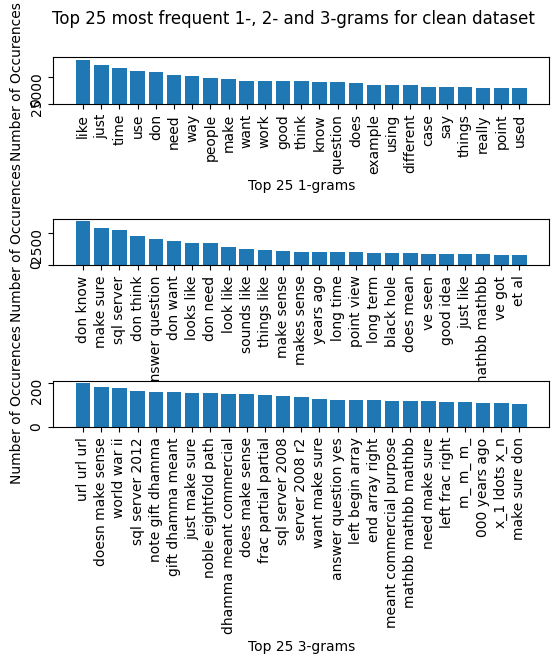

In [97]:
show_1_2_3_gram_plots(ranking1,ranking2,ranking3, title = "Top 25 most frequent 1-, 2- and 3-grams for clean dataset")

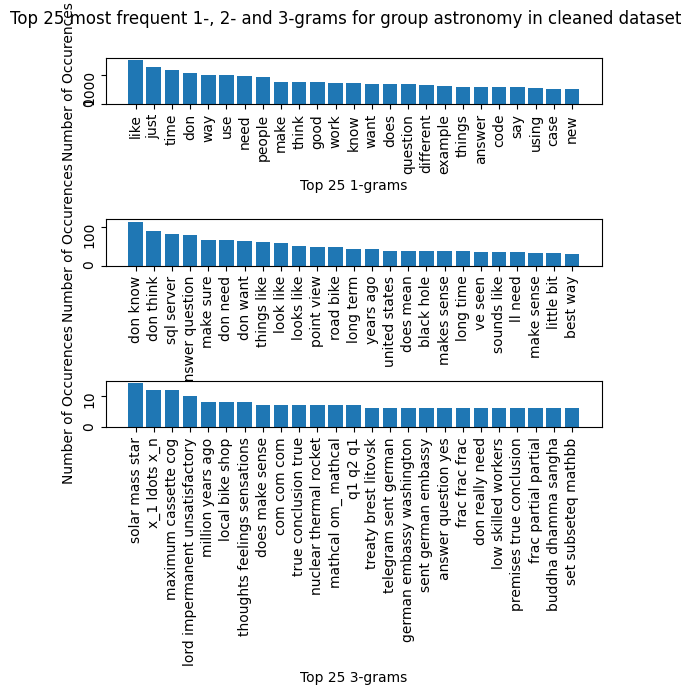

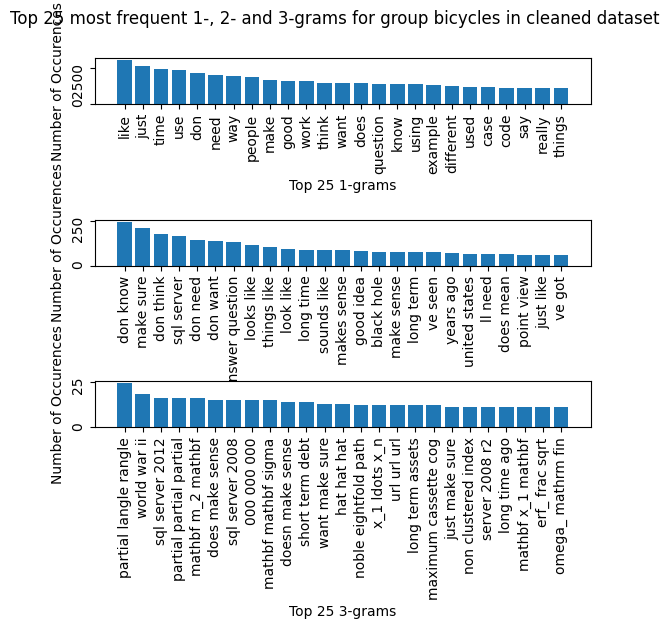

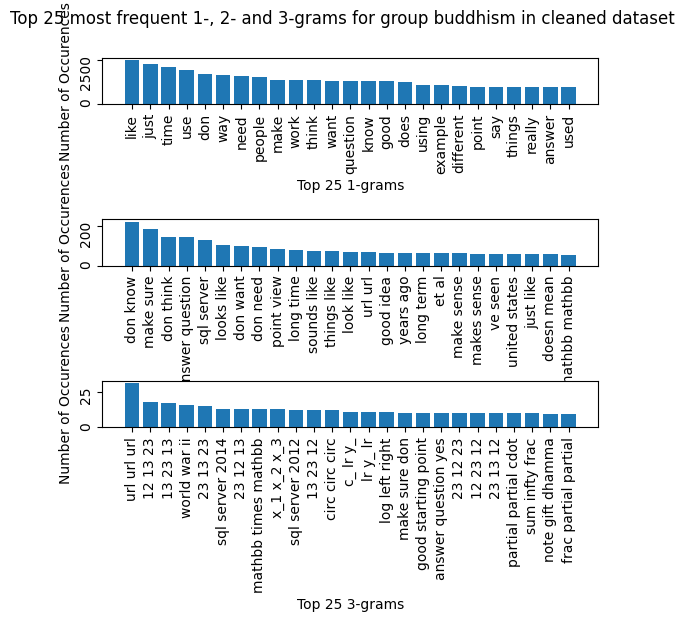

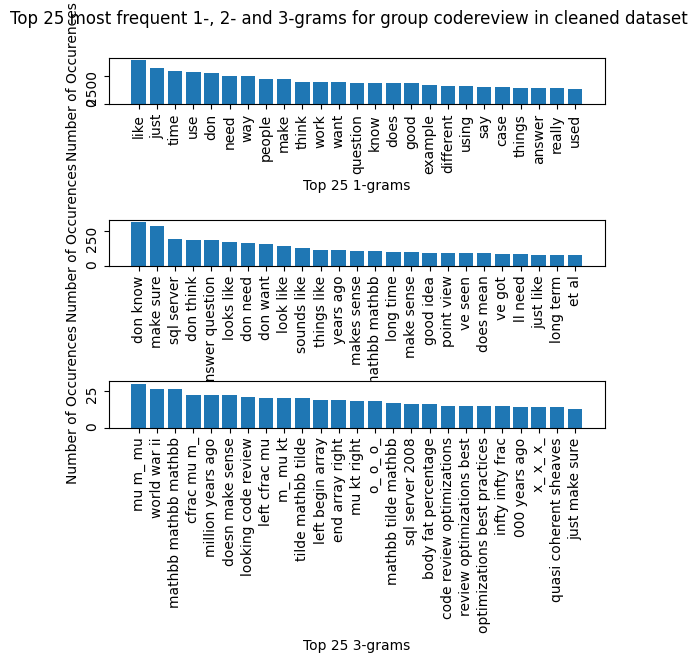

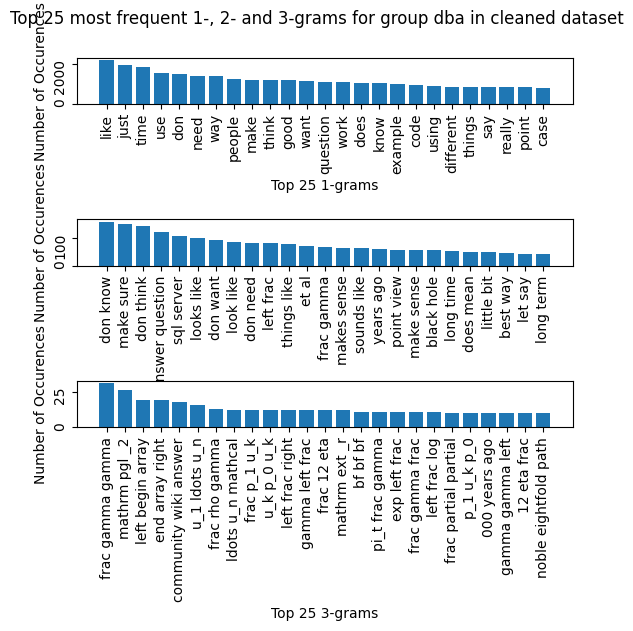

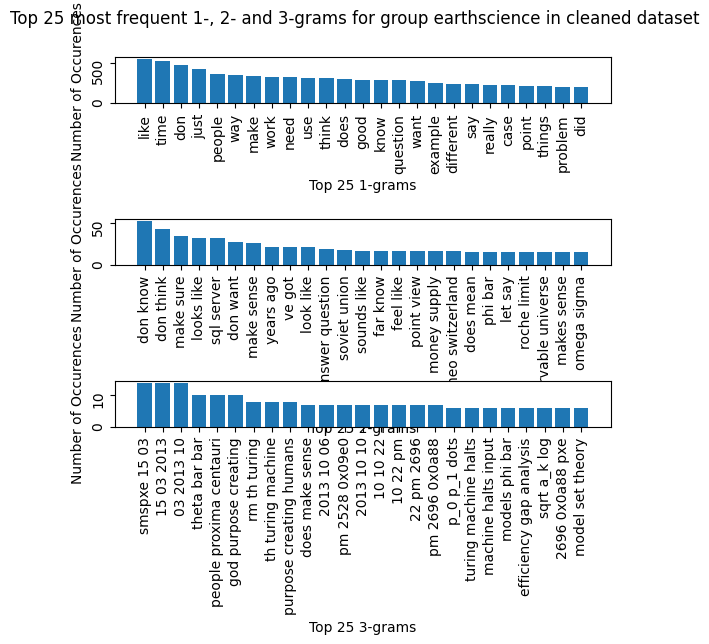

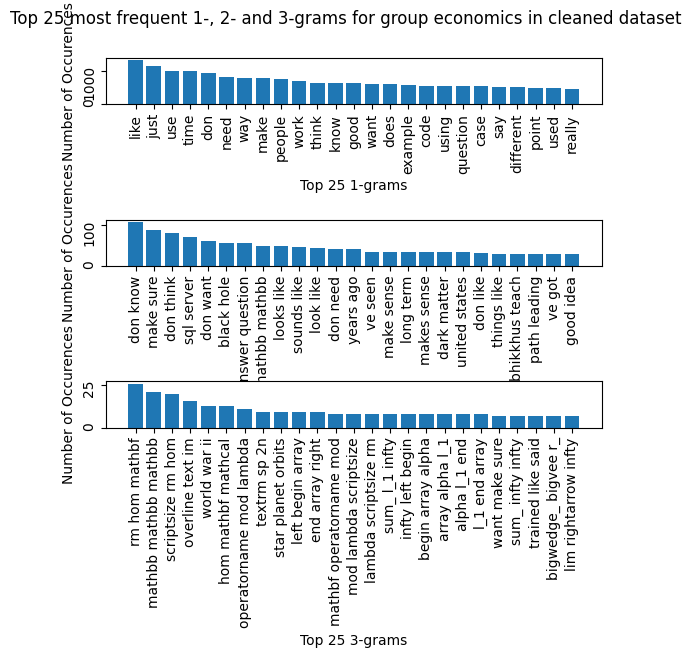

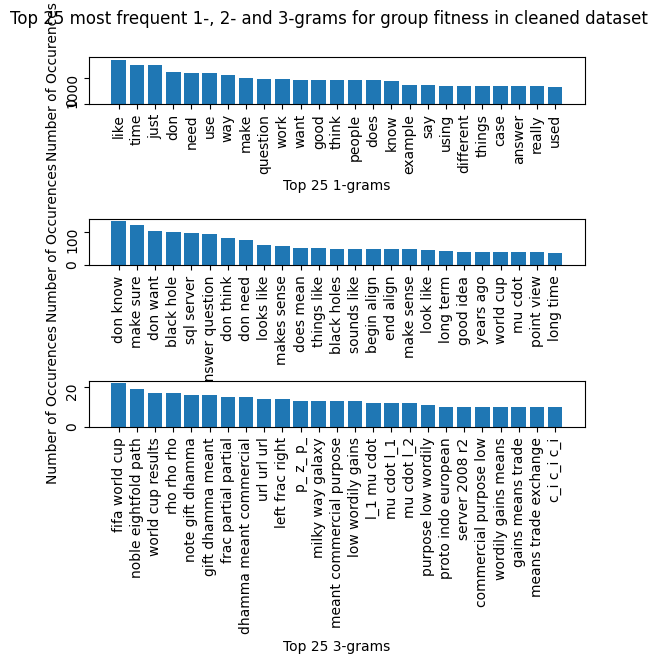

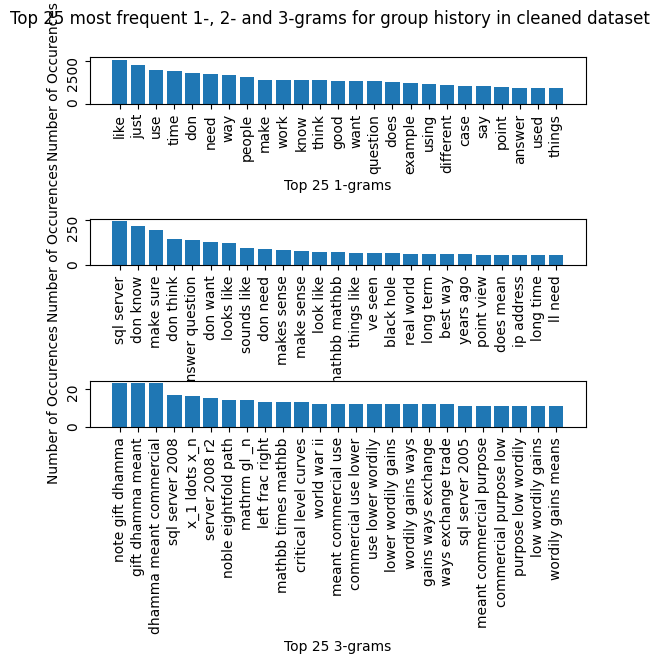

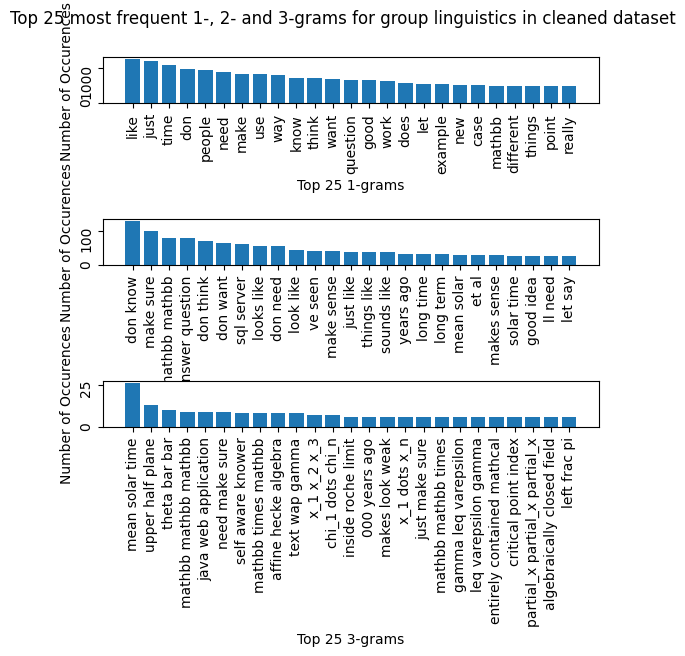

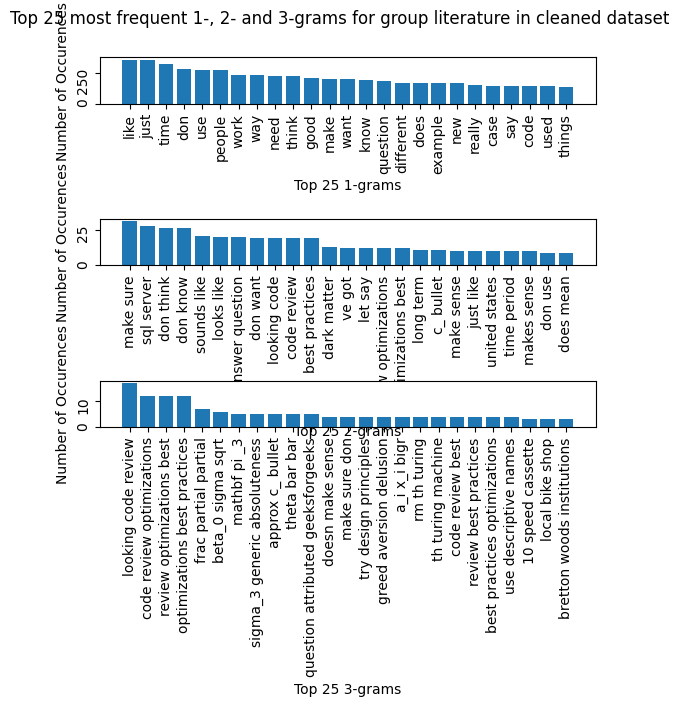

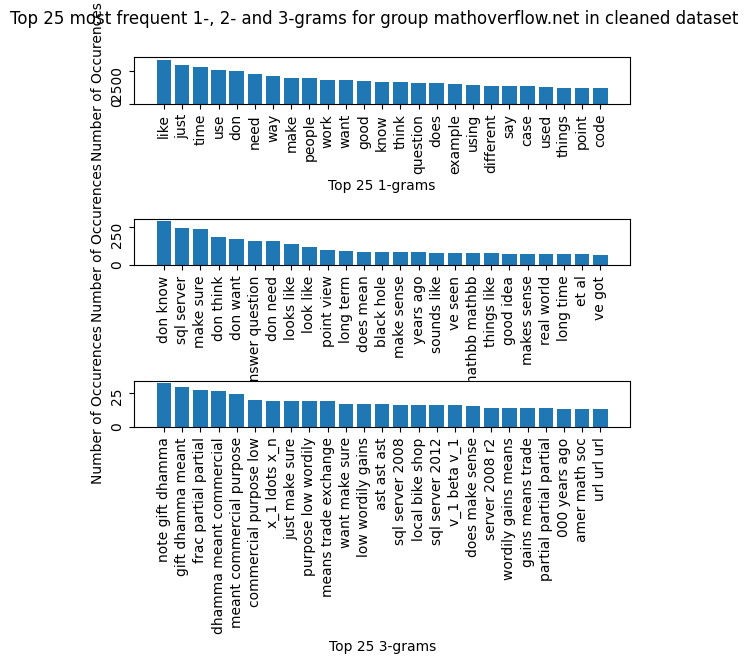

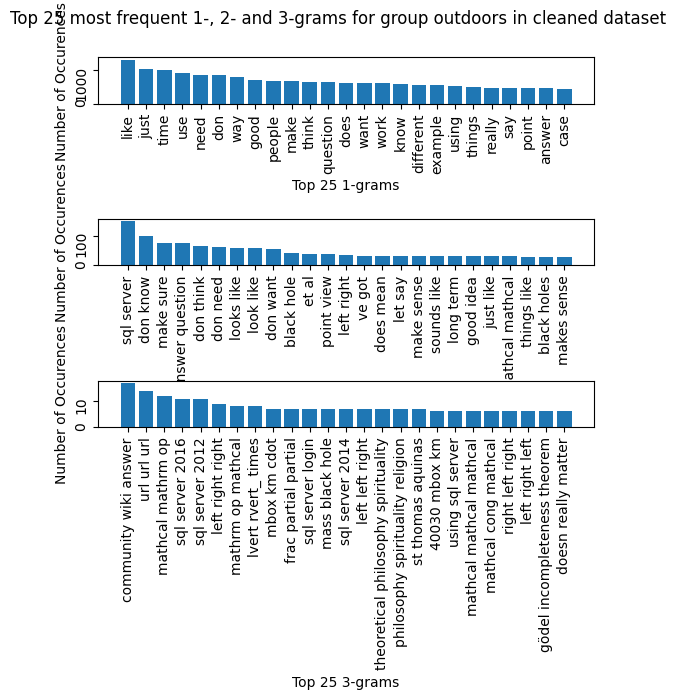

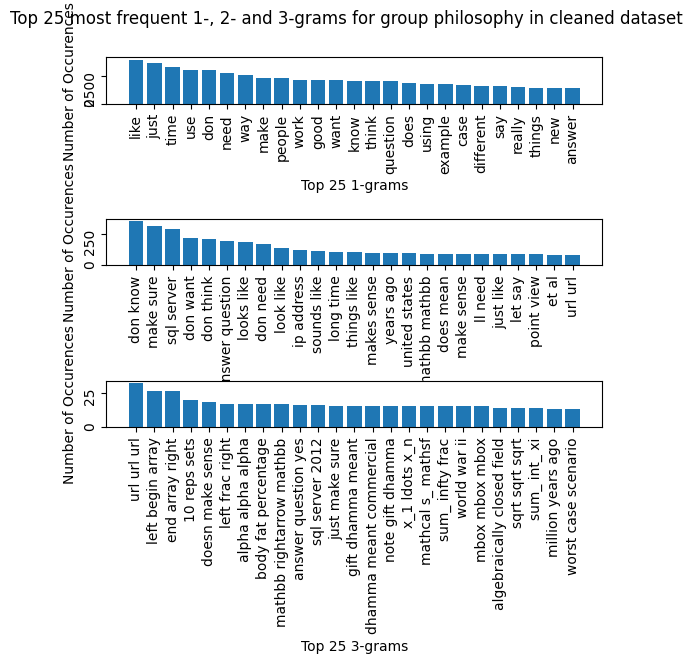

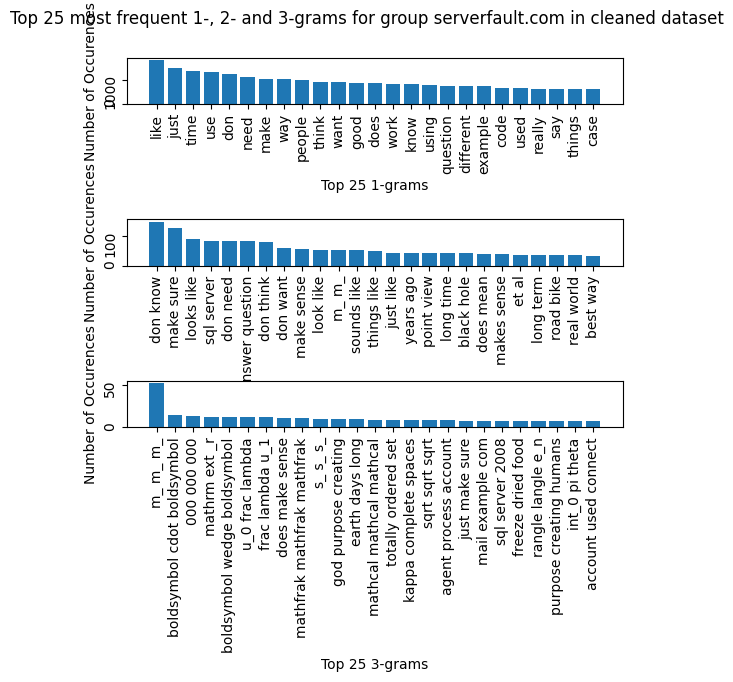

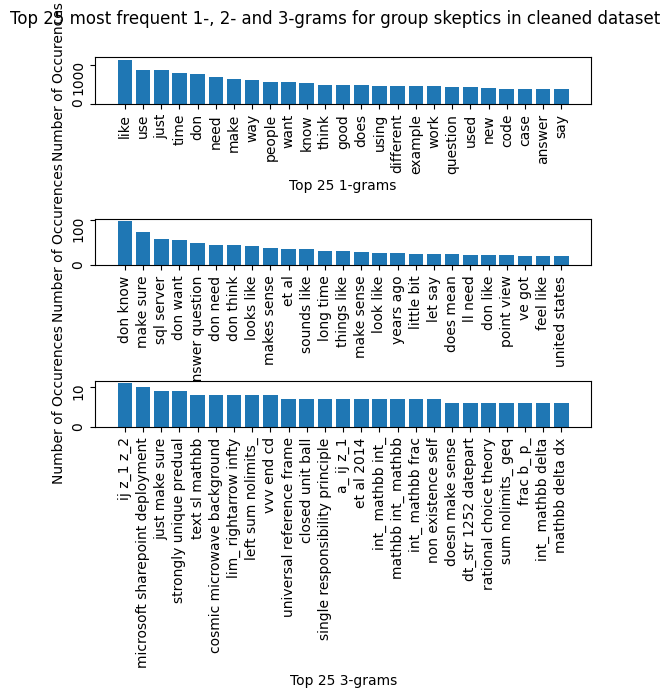

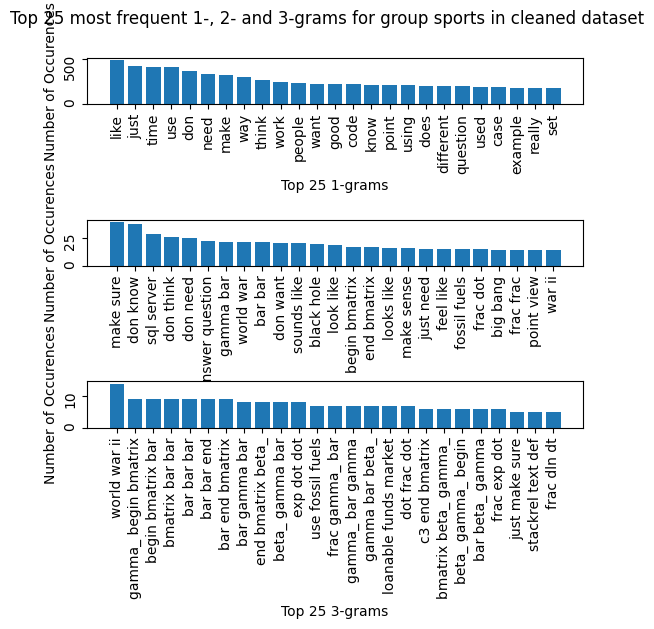

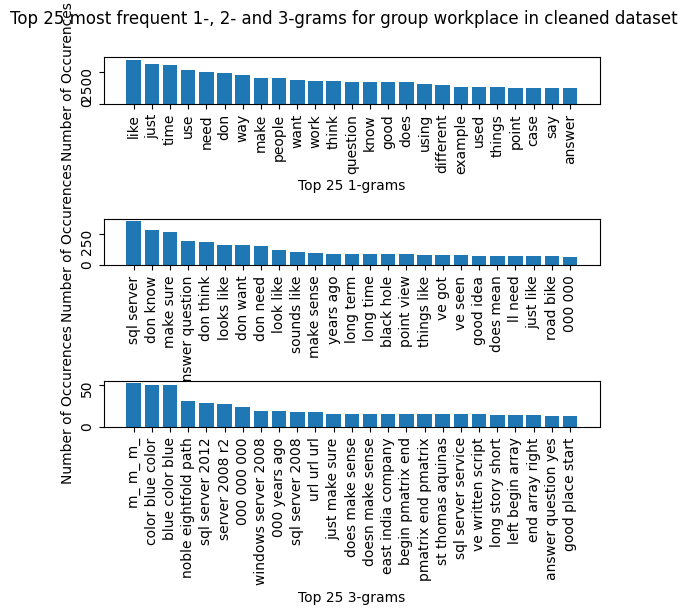

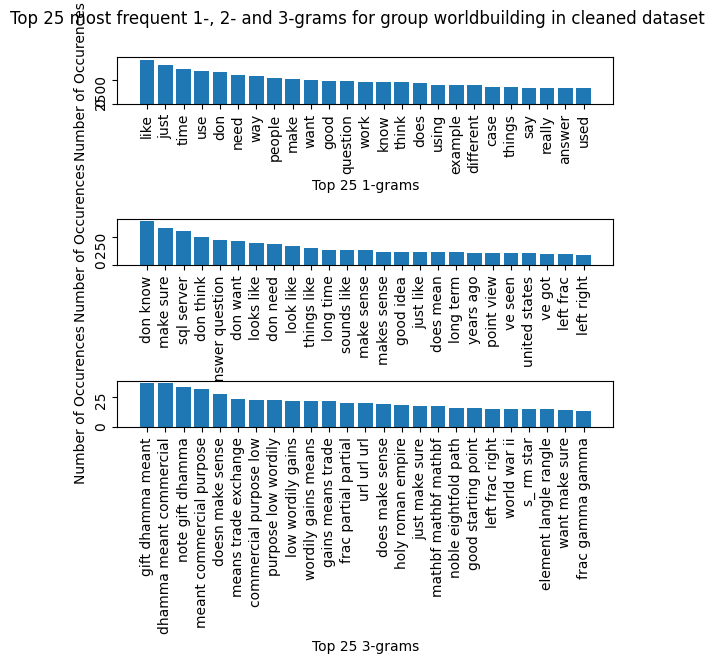

In [99]:
for group in group_site.__iter__():
    vectg_1 = fe.text.CountVectorizer(ngram_range=(1,1), stop_words = "english", preprocessor=stem_wrapper)
    matg_1 = vectg_1.fit_transform(group[1]["problem_txt"])
    vectg_2 = fe.text.CountVectorizer(ngram_range=(2,2), stop_words = "english", preprocessor=stem_wrapper)
    matg_2 = vectg_2.fit_transform(group[1]["problem_txt"])
    vectg_3 = fe.text.CountVectorizer(ngram_range=(3,3), stop_words = "english", preprocessor=stem_wrapper)
    matg_3 = vectg_3.fit_transform(group[1]["problem_txt"])
    ranking_1 = get_ngram_freq_ranking(matg_1, vectg_1)
    ranking_2 = get_ngram_freq_ranking(matg_2, vectg_2)
    ranking_3 = get_ngram_freq_ranking(matg_3, vectg_3)
    show_1_2_3_gram_plots(ranking_1,ranking_2,ranking_3,title = f"Top 25 most frequent 1-, 2- and 3-grams for group {group[0]} in cleaned dataset")

We can see that the n-grams have changed significantly compared to the raw data. In the raw dataset, most of our n-grams were stop words, this is not the case anymore.